In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES = 5

# Necessary imports
import sys
import numpy as np
import torch
from torchmetrics import StructuralSimilarityIndexMeasure, UniversalImageQualityIndex, MeanSquaredError
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import random_split
import warnings
warnings.filterwarnings("ignore")

sys.path.insert(0, '../seismiqb/')
from batchflow import Pipeline, Notifier, set_gpus
from batchflow import B, C, P, R, M, V, D
from batchflow.models.torch import TorchModel, ResBlock

from seismiqb import SeismicDataset, Horizon
from seismiqb import SeismicSampler, Accumulator3D, RegularGrid
from seismiqb import plot

# Set GPU
set_gpus(n=1, min_free_memory=0.4);

env: CUDA_VISIBLE_DEVICES=5


In [2]:
DEVICE = 'cuda:0'
N_ITERS = 200
CROP_SHAPE = (1, 256, 256)
BATCH_SIZE = 16  

# Loading data

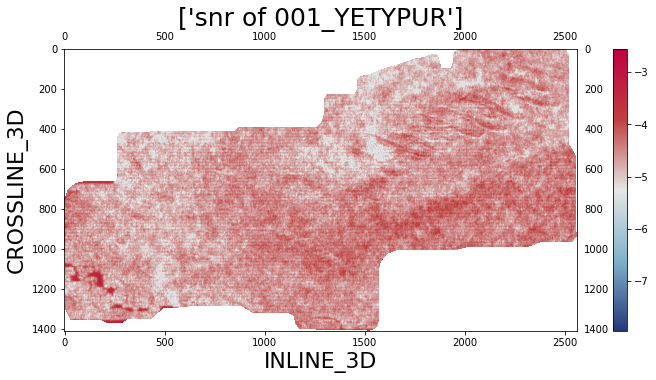

In [3]:
cube_path = '/notebooks/cubes/001_YETYPUR/001_YETYPUR.qblosc'
dataset = SeismicDataset(cube_path)
field = dataset[0]

field.show()

In [ ]:
train_sampler = SeismicSampler(labels=dataset.geometries, crop_shape=CROP_SHAPE,
                              threshold=0.7, shift_height=(0.7, 0.3), ranges=[[0, 1500], [0, 1400], None])
train_sampler.show_sampled()

In [ ]:
val_sampler = SeismicSampler(labels=dataset.geometries, crop_shape=CROP_SHAPE,
                              threshold=0.7, shift_height=(0.7, 0.3), ranges=[[1500, 2700], [0, 1500], None])
val_sampler.show_sampled()

# Model config
## Here is a Unet-like model (without skip between encoder and decoder) with ResBlock

In [ ]:
MODEL_CONFIG = {
    'inputs_shapes': CROP_SHAPE,
                
    'order': ['encoder', 'embedding', 'decoder', 'head'], 

    'encoder': {              
        'type': 'encoder',
        'order':['blocks', 'downsample'],
        'num_stages': 2,     
        'blocks':{'layout': 'cnacn',
                  'channels':[64, 128], 
                  'kernel_size':3,
                  'padding': 1, 
                  'bias': False,
                  'base_block': ResBlock,
                  'n_reps': 1,
                  'bottleneck': False,
                  'attention': True,
                 },
        
        'downsample': {'layout': 'p', 
                       'kernel_size': 2,
                       'stride': 2, 
                       'channels': 'same * 2'},
        'output_type': 'tensor',
    },
    'embedding': {  
        'input_type': 'tensor',
        'output_type': 'tensor',
        'layout': 'cna cna',
        'kernel_size': 3,
        'channels': 256,
    },
    'decoder': {
        'skip': False,
        'type': 'decoder',
        'num_stages': 2,
        'order': ['upsample', 'block'],
        'blocks': {'layout':'cnacn', 'channels':[128, 64], 'kernel_size': 3, 
                   'stride': 1, 'padding': 1, 'bias': False,
                   'base_block': ResBlock,
                   'n_reps': 1,
                   'bottleneck': False,
                   'attention': True,
                  },                                      
        'upsample': {'layout': 't', 'kernel_size': 2, 'stride': 2, 'channels': 'same // 2', 'bias': True}},             
        
    'head': {                     
        'layout': 'c', 
        'channels': 1,
        'kernel_size':1,
        'stride': 1, 
        'padding': 0, 
        'bias': True},
                
    'loss': 'mse',
    'device': DEVICE,
    'microbatch': 1,
    'optimizer': {'name': 'Adam', 'lr': 1e-4}
    
}

# Train model

In [ ]:
train_template = (
    Pipeline()
    # Initialize model
    .init_model(name='denoising_autoencoder', model_class=TorchModel, config=MODEL_CONFIG)
    .init_variable('loss_history', [])

    # Load data
    .make_locations(generator=train_sampler, batch_size=BATCH_SIZE)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images'])
    .normalize(src='images')

    # Training
    .train_model('denoising_autoencoder',
                 inputs=B('images'), targets=B('images'),
                 outputs='loss', save_to=V('loss_history', mode='a'))
)

train_pipeline = train_template << dataset

In [ ]:
batch = train_pipeline.next_batch()
batch.plot_roll(n=4, ncols=4, combine='separate', colorbar=True, labelright=False, title='original')

In [ ]:
notifier = Notifier('t', monitors=['loss_history', 'gpu', 'gpu_memory'])
train_pipeline.run(n_iters=N_ITERS, notifier=notifier)

In [ ]:
notifier.plot()

# Save model

In [ ]:
# train_pipeline.save_model_now('denoising_autoencoder', 'saved_models/denoise_model')

# Validation part

In [ ]:
model = train_pipeline.m('denoising_autoencoder')

val_template = (
    Pipeline()
    # Import model
    .import_model(name='denoising_autoencoder', source=model)

    # Load data
    .make_locations(generator=val_sampler, batch_size=BATCH_SIZE)
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images'])
    .normalize(src='images')

    # Predict with model
    .predict_model('denoising_autoencoder',
                   inputs=B('images'),
                   outputs='predictions',
                   save_to=B('predictions'))

)
val_pipeline = val_template << dataset

In [ ]:
val_batch = val_pipeline.next_batch()
val_batch.plot_roll(n=4, ncols=3, combine='separate', colorbar=True, cmap='Greys_r')